<a href="https://colab.research.google.com/github/AliF74/Coursera-Deep-Learning/blob/master/Convolution_model_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks: Application

Welcome to Course 4's second assignment! In this notebook, you will:

- Create a mood classifer using the TF Keras Sequential API
- Build a ConvNet to identify sign language digits using the TF Keras Functional API

**After this assignment you will be able to:**

- Build and train a ConvNet in TensorFlow for a __binary__ classification problem
- Build and train a ConvNet in TensorFlow for a __multiclass__ classification problem
- Explain different use cases for the Sequential and Functional APIs

To complete this assignment, you should already be familiar with TensorFlow. If you are not, please refer back to the **TensorFlow Tutorial** of the third week of Course 2 ("**Improving deep neural networks**").

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/convolutional-neural-networks/supplement/DS4yP/h-ow-to-refresh-your-workspace).

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /gdrive

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/gdrive'
/content


## Table of Contents

- [1 - Packages](#1)
    - [1.1 - Load the Data and Split the Data into Train/Test Sets](#1-1)
- [2 - Layers in TF Keras](#2)
- [3 - The Sequential API](#3)
    - [3.1 - Create the Sequential Model](#3-1)
        - [Exercise 1 - happyModel](#ex-1)
    - [3.2 - Train and Evaluate the Model](#3-2)
- [4 - The Functional API](#4)
    - [4.1 - Load the SIGNS Dataset](#4-1)
    - [4.2 - Split the Data into Train/Test Sets](#4-2)
    - [4.3 - Forward Propagation](#4-3)
        - [Exercise 2 - convolutional_model](#ex-2)
    - [4.4 - Train the Model](#4-4)
- [5 - History Object](#5)
- [6 - Bibliography](#6)

<a name='1'></a>
## 1 - Packages

As usual, begin by loading in the packages.

In [4]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from cnn_utils import *
from test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

In [5]:
def load_happy_dataset():
    train_dataset = h5py.File('train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [6]:
train_dataset = h5py.File('train_happy.h5', "r")
train_dataset["train_set_x"].shape

OSError: ignored

<a name='1-1'></a>
### 1.1 - Load the Data and Split the Data into Train/Test Sets

You'll be using the Happy House dataset for this part of the assignment, which contains images of peoples' faces. Your task will be to build a ConvNet that determines whether the people in the images are smiling or not -- because they only get to enter the house if they're smiling!  

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

OSError: ignored

You can display the images contained in the dataset. Images are **64x64** pixels in RGB format (3 channels).

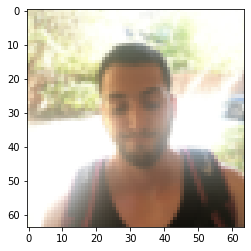

In [ ]:
index = 124
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

<a name='2'></a>
## 2 - Layers in TF Keras 

In the previous assignment, you created layers manually in numpy. In TF Keras, you don't have to write code directly to create layers. Rather, TF Keras has pre-defined layers you can use. 

When you create a layer in TF Keras, you are creating a function that takes some input and transforms it into an output you can reuse later. Nice and easy! 

<a name='3'></a>
## 3 - The Sequential API

In the previous assignment, you built helper functions using `numpy` to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. Keras is a high-level abstraction built on top of TensorFlow, which allows for even more simplified and optimized model creation and training. 

For the first part of this assignment, you'll create a model using TF Keras' Sequential API, which allows you to build layer by layer, and is ideal for building models where each layer has **exactly one** input tensor and **one** output tensor. 

As you'll see, using the Sequential API is simple and straightforward, but is only appropriate for simpler, more straightforward tasks. Later in this notebook you'll spend some time building with a more flexible, powerful alternative: the Functional API. 
 

<a name='3-1'></a>
### 3.1 - Create the Sequential Model

As mentioned earlier, the TensorFlow Keras Sequential API can be used to build simple models with layer operations that proceed in a sequential order. 

You can also add layers incrementally to a Sequential model with the `.add()` method, or remove them using the `.pop()` method, much like you would in a regular Python list.

Actually, you can think of a Sequential model as behaving like a list of layers. Like Python lists, Sequential layers are ordered, and the order in which they are specified matters.  If your model is non-linear or contains layers with multiple inputs or outputs, a Sequential model wouldn't be the right choice!

For any layer construction in Keras, you'll need to specify the input shape in advance. This is because in Keras, the shape of the weights is based on the shape of the inputs. The weights are only created when the model first sees some input data. Sequential models can be created by passing a list of layers to the Sequential constructor, like you will do in the next assignment.

<a name='ex-1'></a>
### Exercise 1 - happyModel

Implement the `happyModel` function below to build the following model: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Take help from [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 

Also, plug in the following parameters for all the steps:

 - [ZeroPadding2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D): padding 3, input shape 64 x 64 x 3
 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 32 7x7 filters, stride 1
 - [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization): for axis 3
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Using default parameters
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 1 neuron and a sigmoid activation. 
 
 
 **Hint:**
 
 Use **tfl** as shorthand for **tensorflow.keras.layers**

In [ ]:
# GRADED FUNCTION: happyModel

def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    model = tf.keras.Sequential([
            ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
            
            ## Conv2D with 32 7x7 filters and stride of 1
            
            ## BatchNormalization for axis 3
            
            ## ReLU
            
            ## Max Pooling 2D with default parameters
            
            ## Flatten layer
            
            ## Dense layer with 1 unit for output & 'sigmoid' activation
            
            # YOUR CODE STARTS HERE
        # tf.keras.layers.ZeroPadding2D(padding = (3,3), input_shape = (64, 64, 3), data_format="channels_last"),
        # tf.keras.layers.Conv2D(filters = 32, kernel_size= (7,7), strides= (1,1), name = 'conv0'),
        # tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0'),
        # tf.keras.layers.ReLU(),
        # tf.keras.layers.MaxPooling2D(pool_size= (2,2), name = 'max_pool0'),
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(units = 1, activation = 'sigmoid', name = 'fc'),
        # ])
        
        tf.keras.layers.ZeroPadding2D(padding=(3,3),input_shape=(64, 64, 3), data_format="channels_last"),
    
        tf.keras.layers.Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0'),
        
        
        tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0'),
        
        tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0),
        
        tf.keras.layers.MaxPooling2D((2, 2), name='max_pool0'),
    
        tf.keras.layers.Flatten(),
    
        tf.keras.layers.Dense(1, activation='sigmoid', name='fc'),            
            
            # YOUR CODE ENDS HERE
        ])
    
    return model

In [ ]:
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)
    
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]
    
comparator(summary(happy_model), output)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']
All tests passed!


In [ ]:
for layer in summary(happy_model):
    print(layer)
    

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']


Now that your model is created, you can compile it for training with an optimizer and loss of your choice. When the string `accuracy` is specified as a metric, the type of accuracy used will be automatically converted based on the loss function used. This is one of the many optimizations built into TensorFlow that make your life easier! If you'd like to read more on how the compiler operates, check the docs [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile).

In [ ]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

It's time to check your model's parameters with the `.summary()` method. This will display the types of layers you have, the shape of the outputs, and how many parameters are in each layer. 

In [ ]:
happy_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_3 (ZeroPaddi  (None, 70, 70, 3)        0         
 ng2D)                                                           
                                                                 
 conv0 (Conv2D)              (None, 64, 64, 32)        4736      
                                                                 
 bn0 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 re_lu_9 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 32, 32, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                      

<a name='3-2'></a>
### 3.2 - Train and Evaluate the Model

After creating the model, compiling it with your choice of optimizer and loss function, and doing a sanity check on its contents, you are now ready to build! 

Simply call `.fit()` to train. That's it! No need for mini-batching, saving, or complex backpropagation computations. That's all been done for you, as you're using a TensorFlow dataset with the batches specified already. You do have the option to specify epoch number or minibatch size if you like (for example, in the case of an un-batched dataset).

In [ ]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 [==============================] - 1s 5ms/step - loss: 0.7373 - accuracy: 0.7717
Epoch 2/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1611 - accuracy: 0.9467
Epoch 3/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1221 - accuracy: 0.9483
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1061 - accuracy: 0.9500
Epoch 5/10
38/38 [==============================] - 0s 5ms/step - loss: 0.2587 - accuracy: 0.9150
Epoch 6/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1222 - accuracy: 0.9533
Epoch 7/10
38/38 [==============================] - 0s 5ms/step - loss: 0.0791 - accuracy: 0.9650
Epoch 8/10
38/38 [==============================] - 0s 5ms/step - loss: 0.0744 - accuracy: 0.9700
Epoch 9/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1221 - accuracy: 0.9450
Epoch 10/10
38/38 [==============================] - 0s 5ms/step - loss: 0.0925 - accuracy: 0.9767


After that completes, just use `.evaluate()` to evaluate against your test set. This function will print the value of the loss function and the performance metrics specified during the compilation of the model. In this case, the `binary_crossentropy` and the `accuracy` respectively.

In [ ]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 5ms/step - loss: 0.1587 - accuracy: 0.9200


[0.1586914211511612, 0.9200000166893005]

Easy, right? But what if you need to build a model with shared layers, branches, or multiple inputs and outputs? This is where Sequential, with its beautifully simple yet limited functionality, won't be able to help you. 

Next up: Enter the Functional API, your slightly more complex, highly flexible friend.  

<a name='4'></a>
## 4 - The Functional API

<img src="images/seq_vs_func.png" style="width:350px;height:200px;">

In [7]:
def load_signs_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

<a name='4-1'></a>
### 4.1 - Load the SIGNS Dataset

As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [8]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

<img src="images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 0


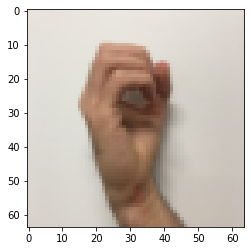

In [9]:
# Example of an image from the dataset
index = 20
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [10]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [11]:
# GRADED FUNCTION: convolutional_model

def convolutional_model(input_shape):

    input_img = tf.keras.Input(shape=input_shape)

    Z1 = tf.keras.layers.Conv2D(filters = 8 , kernel_size= (4,4), strides = (1,1), padding='same')(input_img)
    A1 = tf.keras.layers.ReLU()(Z1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=(8, 8), padding='same')(A1)
    Z2 = tf.keras.layers.Conv2D(filters = 16 , kernel_size= (2,2), strides = (1,1), padding='same')(P1)
    A2 = tf.keras.layers.ReLU()(Z2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(4, 4), padding='same')(A2)
    F = tf.keras.layers.Flatten()(P2)
    outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)    
    
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [12]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
  

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         392       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 16)          0         
                                                             

Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are handled inside the object model! 

<a name='4-4'></a>
### 4.4 - Train the Model

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 8s 26ms/step - loss: 1.7956 - accuracy: 0.1731 - val_loss: 1.7910 - val_accuracy: 0.1917
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 1.7815 - accuracy: 0.2250 - val_loss: 1.7855 - val_accuracy: 0.2000
Epoch 3/100
17/17 [==============================] - 0s 10ms/step - loss: 1.7735 - accuracy: 0.2602 - val_loss: 1.7803 - val_accuracy: 0.2417
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 1.7644 - accuracy: 0.2889 - val_loss: 1.7735 - val_accuracy: 0.2500
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 1.7540 - accuracy: 0.3046 - val_loss: 1.7648 - val_accuracy: 0.2667
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 1.7404 - accuracy: 0.3704 - val_loss: 1.7542 - val_accuracy: 0.3083
Epoch 7/100
17/17 [==============================] - 0s 9ms/step - loss: 1.7229 - accuracy: 0.4000 - val_loss: 1.7405 - val_accuracy: 0.4083
Epoch 8/1

<a name='5'></a>
## 5 - History Object 

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that you can retrieve at `history.history`: 

In [14]:
history.history

{'loss': [1.795583963394165,
  1.7815287113189697,
  1.7734968662261963,
  1.764426589012146,
  1.7539597749710083,
  1.7403665781021118,
  1.7228533029556274,
  1.7009100914001465,
  1.6738380193710327,
  1.6388508081436157,
  1.5968669652938843,
  1.5481657981872559,
  1.4936665296554565,
  1.4364688396453857,
  1.3808835744857788,
  1.3257824182510376,
  1.2732964754104614,
  1.22476065158844,
  1.1803696155548096,
  1.1400883197784424,
  1.1027811765670776,
  1.0680826902389526,
  1.0357465744018555,
  1.0065772533416748,
  0.9793722629547119,
  0.9538798928260803,
  0.9310480356216431,
  0.9092020392417908,
  0.8895487785339355,
  0.8703367114067078,
  0.8536921739578247,
  0.8377067446708679,
  0.8213791251182556,
  0.8073652386665344,
  0.792203426361084,
  0.7793596386909485,
  0.7673159241676331,
  0.7545775175094604,
  0.7427039742469788,
  0.7310270071029663,
  0.7193631529808044,
  0.709006130695343,
  0.6983628273010254,
  0.6886544823646545,
  0.6788438558578491,
  0.6689

Now visualize the loss over time using `history.history`: 

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

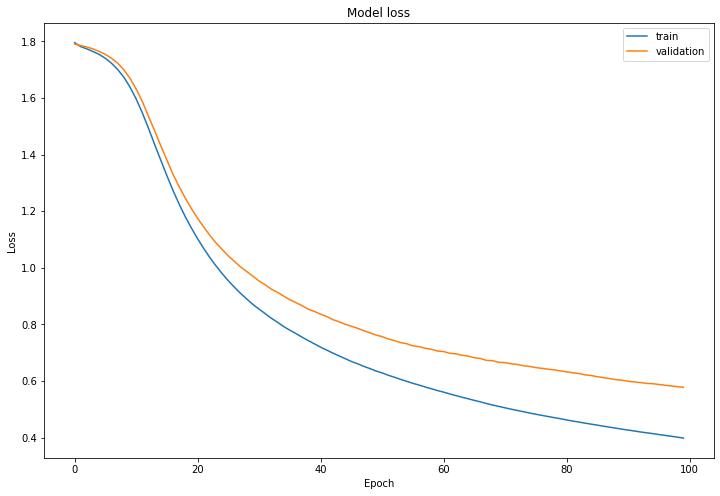

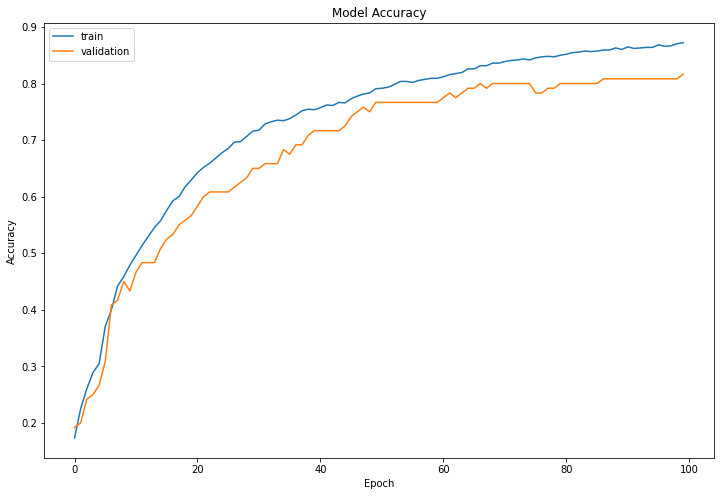

In [15]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

**Congratulations**! You've finished the assignment and built two models: One that recognizes  smiles, and another that recognizes SIGN language with almost 80% accuracy on the test set. In addition to that, you now also understand the applications of two Keras APIs: Sequential and Functional. Nicely done! 

By now, you know a bit about how the Functional API works and may have glimpsed the possibilities. In your next assignment, you'll really get a feel for its power when you get the opportunity to build a very deep ConvNet, using ResNets! 

In [ ]:
arr = np.array(train_dataset)
print(arr)

<BatchDataset shapes: ((None, 64, 64, 3), (None, 6)), types: (tf.float64, tf.float64)>


<a name='6'></a>
## 6 - Bibliography

You're always encouraged to read the official documentation. To that end, you can find the docs for the Sequential and Functional APIs here: 

https://www.tensorflow.org/guide/keras/sequential_model

https://www.tensorflow.org/guide/keras/functional